<a href="https://colab.research.google.com/github/otvet4ikov/castle/blob/main/water.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
    <h1><center>Вступление</center></h1>
</div>

Описание [датасета](https://www.kaggle.com/datasets/adityakadiwal/water-potability).

Данный датасет содержит информацию о качестве воды с помощью некоторых параметров мы предсказываем пригодна ли вода для питья или нет. В датасете содержится 14 параметров
1. pH value: Кислотность воды от 0 до 14.
2. Hardness: Жёсткость воды 
3. Solids: Общее количество растворенных твердых веществ в промилле.
4. Chloramines: Количество хлораминов.
5. Sulfate: Количество растворенных сульфатов.
6. Conductivity: Электропроводность воды.
7. Organic_carbon: Количество органического углерода.
8. Trihalomethanes: Количество тригалометанов.
9. Turbidity: Мера светоизлучающих свойств воды.
10. Potability: Безопасность воды. Пригодный для питья - 1 и непригодный для питья - 0

Установим библиотеку catboost

In [30]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
# базовые библиотеки
import pandas as pd
import numpy as np


# библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# библиотеки для preprocessing и подсчета оценок модели
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, shuffle
from sklearn.metrics import accuracy_score, classification_report

# библиотеки для моделирования
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC

Импортируем датасет и выведем основную информацию о нем

In [32]:
water_potability_data = pd.read_csv('water_potability.csv')

In [33]:
print(water_potability_data.dtypes,'\n', 'shape:',water_potability_data.shape)

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object 
 shape: (3276, 10)


In [34]:
water_potability_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


<div>
    <h1><center>Предобработка данных</center></h1>
</div>

Посмотрим сколько пропущенных значений есть и удалим их

In [35]:
water_potability_data.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [36]:
water_potability_data = water_potability_data.dropna()

Построим Box Plots для величин

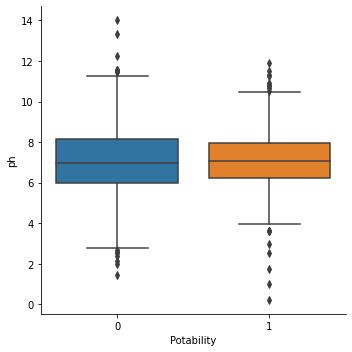

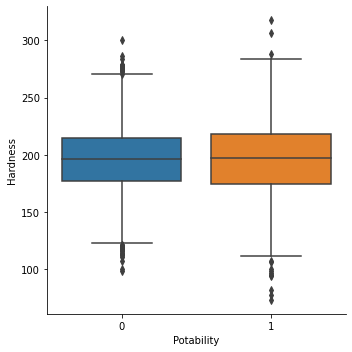

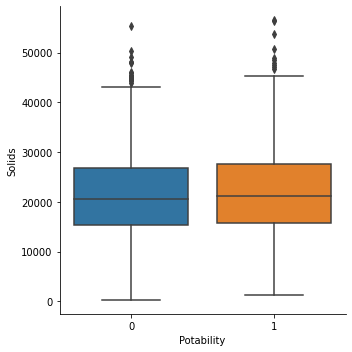

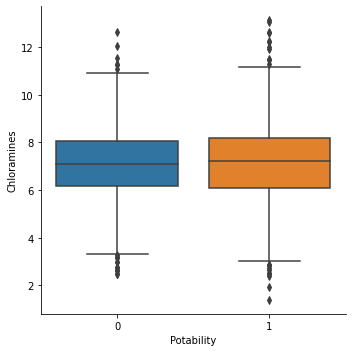

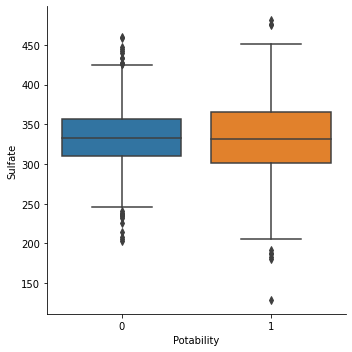

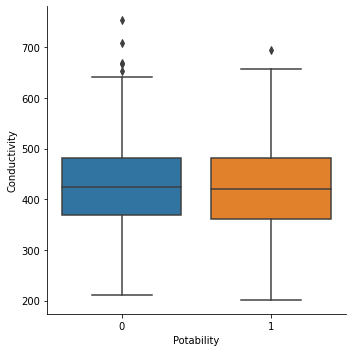

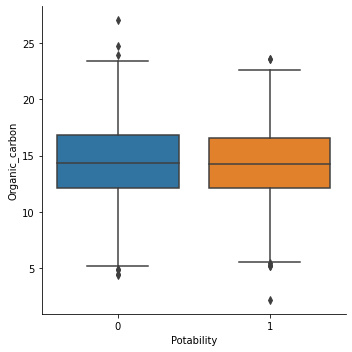

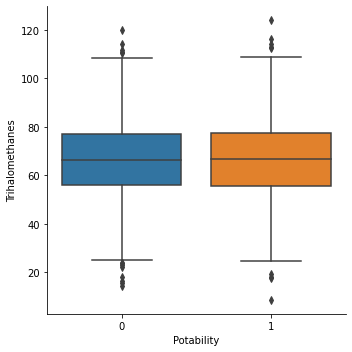

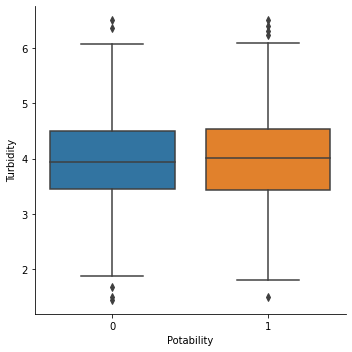

In [37]:
for column in water_potability_data.drop('Potability', axis=1):
    sns.catplot(x="Potability", y=column, data=water_potability_data, kind="box")
    plt.show()

Построим распределение всех величин и корреляцию

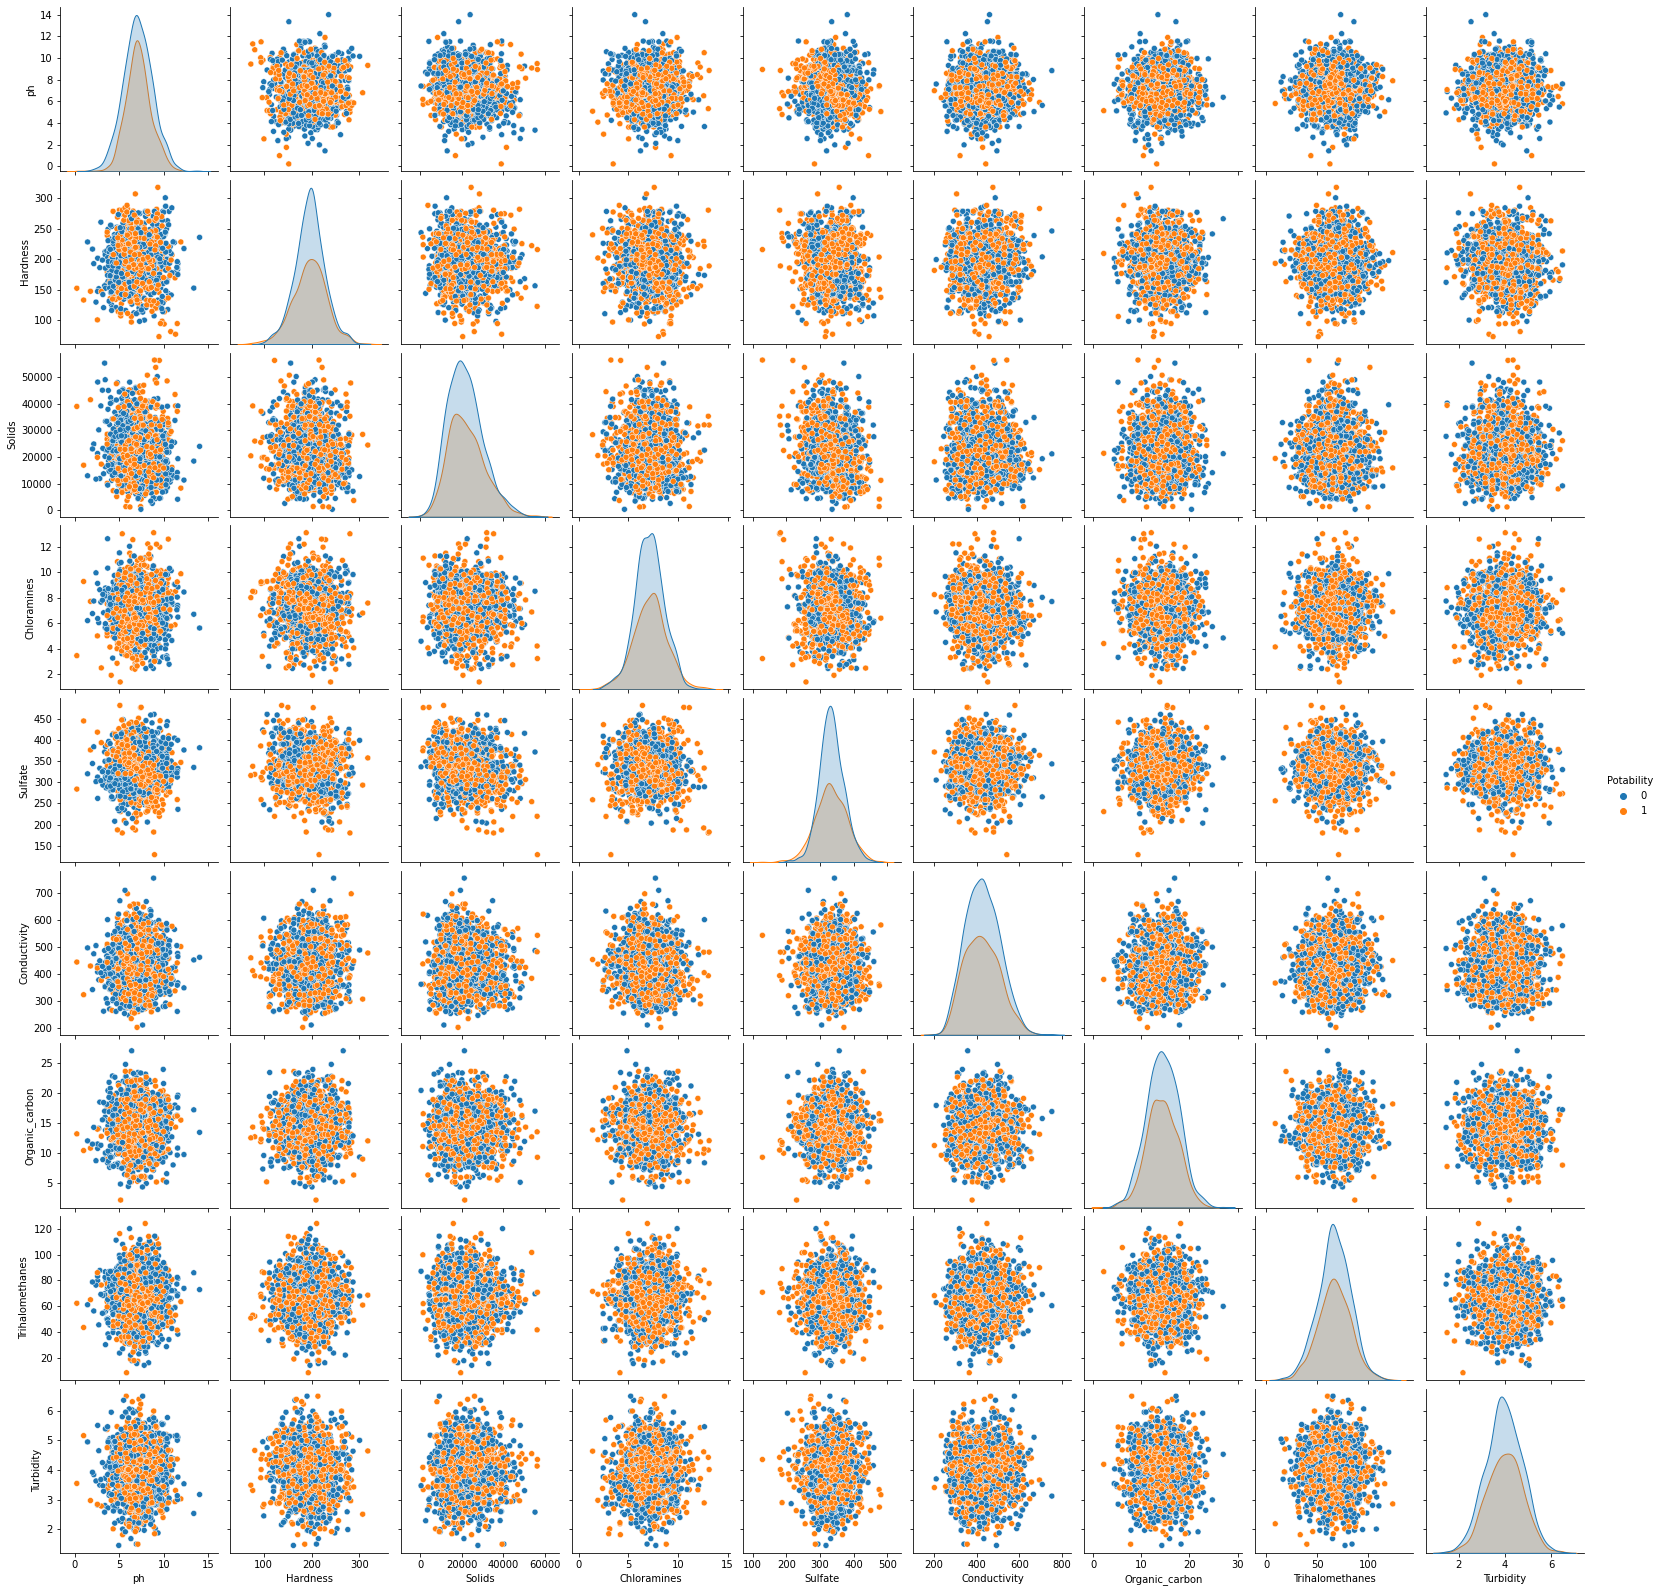

In [38]:
sns.pairplot(water_potability_data, hue='Potability');

In [39]:
corr = water_potability_data.drop('Potability',axis=1).corr()
corr

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
ph,1.000000,0.108948,-0.087615,-0.024768,0.010524,0.014128,0.028375,0.018278,-0.035849
Hardness,0.108948,1.000000,-0.053269,-0.022685,-0.108521,0.011731,0.013224,-0.015400,-0.034831
Solids,-0.087615,-0.053269,1.000000,-0.051789,-0.162769,-0.005198,-0.005484,-0.015668,0.019409
Chloramines,-0.024768,-0.022685,-0.051789,1.000000,0.006254,-0.028277,-0.023808,0.014990,0.013137
Sulfate,0.010524,-0.108521,-0.162769,0.006254,1.000000,-0.016192,0.026776,-0.023347,-0.009934
Conductivity,0.014128,0.011731,-0.005198,-0.028277,-0.016192,1.000000,0.015647,0.004888,0.012495
Organic_carbon,0.028375,0.013224,-0.005484,-0.023808,0.026776,0.015647,1.000000,-0.005667,-0.015428
Trihalomethanes,0.018278,-0.015400,-0.015668,0.014990,-0.023347,0.004888,-0.005667,1.000000,-0.020497
Turbidity,-0.035849,-0.034831,0.019409,0.013137,-0.009934,0.012495,-0.015428,-0.020497,1.000000


Здесь видно, что среди классов низкая корреляция.

Посмотрим на дисбаланс классов 

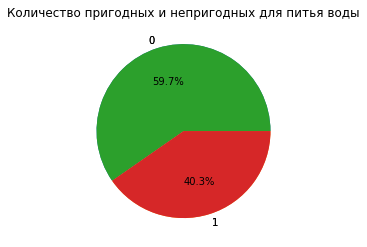

In [40]:
vals = water_potability_data['Potability'].value_counts()
labels = water_potability_data['Potability'].unique()
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.pie(vals, labels=labels)
ax.set_title('Количество пригодных и непригодных для питья воды')
plt.show()

Видно, что наблюдается дисбаланс при этом в сторону непригодной воды. Сбланасируем классы, для этого добавим значений в класс 1.

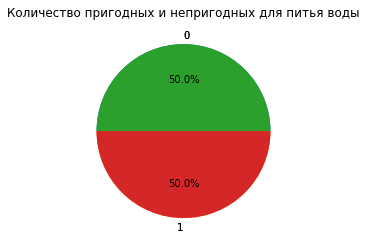

In [41]:
zero  = water_potability_data[water_potability_data['Potability']==0]   
one = water_potability_data[water_potability_data['Potability']==1]  



df_minority_upsampled = resample(one, replace = True, n_samples = 1200) 

df = pd.concat([zero, df_minority_upsampled])
water_potability_data = shuffle(df)


vals = df['Potability'].value_counts()
labels = df['Potability'].unique()
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.pie(vals, labels=labels)
ax.set_title('Количество пригодных и непригодных для питья воды')
plt.show()

Разделим весь датасет на признаки и целевые переменные. 

In [42]:
X = water_potability_data.drop('Potability', axis=1)
y = water_potability_data.Potability

Произведем нормирование признаков и построим распределение величин

In [43]:
sc = StandardScaler()
features= X.columns
X[features] = sc.fit_transform(X[features])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

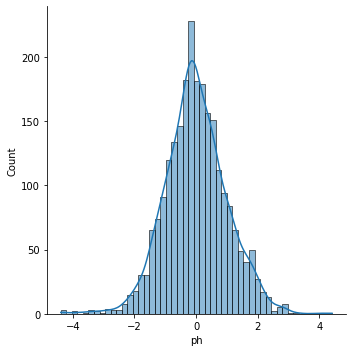

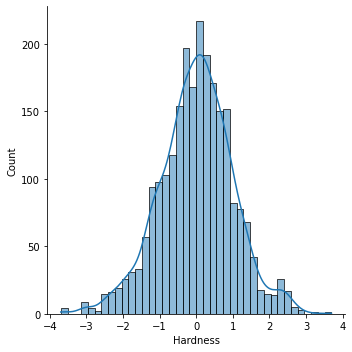

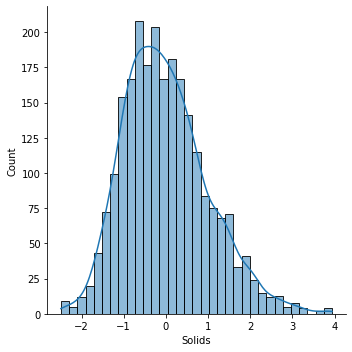

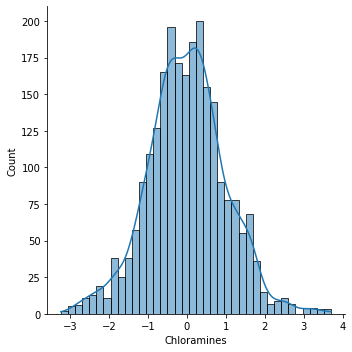

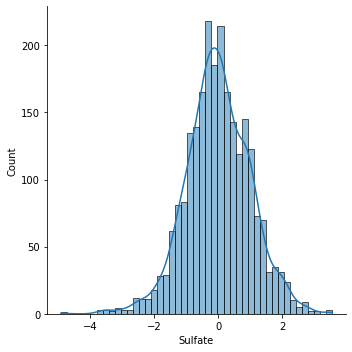

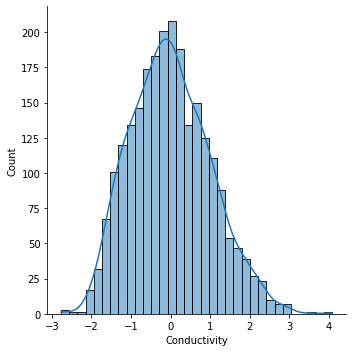

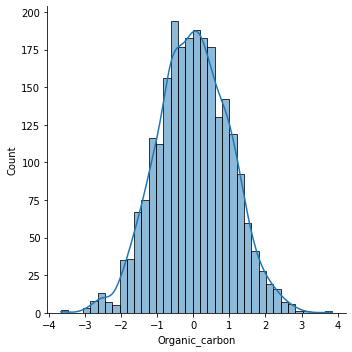

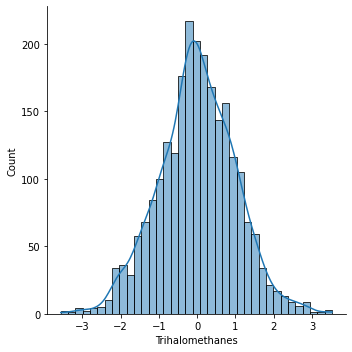

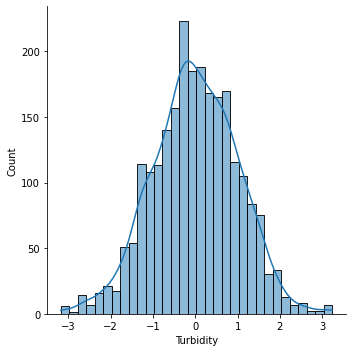

In [44]:
for column in X.columns:
    sns.displot(X[column], kde = True)
    plt.show()

In [45]:
X.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03
mean,-2.516506e-16,-5.891584e-16,1.687539e-16,5.177340e-16,3.700743e-16,3.759955e-16,-1.894781e-16,3.449093e-16,-6.779762e-16
std,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00
min,-4.392704e+00,-3.703212e+00,-2.491732e+00,-3.238164e+00,-4.918848e+00,-2.769527e+00,-3.674870e+00,-3.564270e+00,-3.178494e+00
25%,-6.264180e-01,-6.006855e-01,-7.158841e-01,-6.246946e-01,-6.228912e-01,-7.231062e-01,-6.768571e-01,-6.306838e-01,-6.629937e-01
50%,-4.640615e-02,4.725383e-02,-1.063863e-01,-1.595435e-03,-1.123197e-02,-5.416636e-02,-2.421385e-03,-2.118936e-03,-9.364639e-03
75%,5.976573e-01,6.401261e-01,5.965578e-01,6.160418e-01,6.600632e-01,6.675310e-01,6.962320e-01,6.735614e-01,6.995292e-01
max,4.416903e+00,3.696895e+00,3.941650e+00,3.703553e+00,3.560102e+00,4.079812e+00,3.845746e+00,3.523814e+00,3.231657e+00


<div>
    <h1><center>Моделирование</center></h1>
</div>


1. Logistic regression

In [46]:
classifier = LogisticRegression(solver='lbfgs',random_state=42)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

accuracy_clf = accuracy_score(y_test, predictions)

print(accuracy_clf, '\n', classification_report(y_test, predictions))

0.4583333333333333 
               precision    recall  f1-score   support

           0       0.50      0.44      0.47       129
           1       0.42      0.48      0.45       111

    accuracy                           0.46       240
   macro avg       0.46      0.46      0.46       240
weighted avg       0.46      0.46      0.46       240



2. Random forest

In [72]:
clf_rf = RandomForestClassifier(random_state=42)



parametrs = {'n_estimators':[100, 200, 300, 350, 400,  500], 'min_samples_leaf':[2, 10, 30, 40]}
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)
best_clf_rf = grid_search_cv_clf.best_estimator_

In [73]:
y_pred_rf  = best_clf_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)

print(accuracy, '\n', classification_report(y_test, y_pred_rf))


0.8416666666666667 
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       129
           1       0.81      0.86      0.83       111

    accuracy                           0.84       240
   macro avg       0.84      0.84      0.84       240
weighted avg       0.84      0.84      0.84       240



3. Gradient boosting

In [70]:
params_gbcf = {'n_estimators': [100, 200, 300, 400],
          'learning_rate':[0.03, 0.2, 0.4, 0.8, 1]
          }

gbcf = GradientBoostingClassifier()


grid_gbcf = GridSearchCV(gbcf, param_grid=params_gbcf, cv=5)
grid_gbcf.fit(X_train, y_train)
best_gbcf = grid_gbcf.best_estimator_


In [71]:
y_pred_gbcf  = best_gbcf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_gbcf )

print(accuracy_rf, '\n', classification_report(y_test, y_pred_gbcf ))

0.7958333333333333 
               precision    recall  f1-score   support

           0       0.86      0.74      0.80       129
           1       0.74      0.86      0.79       111

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240



4. XGBoost

In [51]:
xgb = XGBClassifier()

params_xgb = {'n_estimators': [50,100,250,400,600,800,1000], 'learning_rate': [0.2,0.5,0.8,1]}
rs_xgb =  RandomizedSearchCV(xgb, param_distributions=params_xgb, cv=5)
rs_xgb.fit(X_train, y_train)

best_rs_xgb = rs_xgb.best_estimator_

In [52]:
y_pred_rs_xgb  = best_rs_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_rs_xgb )

print(accuracy_xgb, '\n', classification_report(y_test, y_pred_rs_xgb))

0.7958333333333333 
               precision    recall  f1-score   support

           0       0.86      0.74      0.80       129
           1       0.74      0.86      0.79       111

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240



5. Catboost 

In [68]:
cb = CatBoostClassifier(random_state=42)

params_cb = {'n_estimators': [50,100,250,400,600], 
             'learning_rate': [0.2,0.5,0.8,1], 
             'l2_leaf_reg': [1, 3, 5, 7, 9],
             'verbose': [False]}
rs_cb =  RandomizedSearchCV(cb, param_distributions=params_cb, cv=5)
rs_cb.fit(X_train, y_train)

best_rs_cb = rs_cb.best_estimator_

In [69]:
y_pred_rs_cb  = best_rs_cb.predict(X_test)
accuracy_cb = accuracy_score(y_test, y_pred_rs_cb)

print(accuracy_cb, '\n', classification_report(y_test, y_pred_rs_cb))

0.8208333333333333 
               precision    recall  f1-score   support

           0       0.87      0.78      0.82       129
           1       0.77      0.86      0.82       111

    accuracy                           0.82       240
   macro avg       0.82      0.82      0.82       240
weighted avg       0.83      0.82      0.82       240



6. Стэкинг с использованием случайного леса, метода главных компонент и логистической регрессии в качестве финальной модели

In [66]:
estimators = [
              ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
              ('svr', make_pipeline(StandardScaler(),
                        LinearSVC(random_state=42)))
]
clf = StackingClassifier(
estimators=estimators, final_estimator=CatBoostClassifier(verbose=False))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy= accuracy_score(y_test, y_pred)

print(accuracy, '\n', classification_report(y_test, y_pred))


0.8458333333333333 
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       129
           1       0.88      0.77      0.82       111

    accuracy                           0.85       240
   macro avg       0.85      0.84      0.84       240
weighted avg       0.85      0.85      0.84       240



<div>
    <h1><center>Заключение</center></h1>
</div>

1. Данный датасет содержал много пропущенных значений.
2. Все значения были распределены близко к нормальному.
3. Коэффициенты корреляции между признаками были очень низкими.
4. Random и CatBoost работали лучше всего для обучения модели.
5. Наибольшую точность дал ансамблевый способ с точностью 0.8458.

